In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Problem 1

Let's build condidence intervals for Normal model with the mean $\mu$ and the variance $\sigma^2$.

Cental statistic:

## $\sqrt{n}\frac{\bar{x}-\mu}{s}$

Where $s$ is the Bessel corrected standard deviation. The central statistic follows Student's t-distribution with degrees of freedom equal $n-1$.

## $t_{\frac{\alpha}{2}}< \sqrt{n}\frac{\bar{x}-\mu}{s} < t_{1-\frac{\alpha}{2}} $

## $t_{\frac{\alpha}{2}}\frac{s}{\sqrt{n}}< \bar{x}-\mu < t_{1-\frac{\alpha}{2}}\frac{s}{\sqrt{n}} $

## $\bar{x}-t_{1-\frac{\alpha}{2}}\frac{s}{\sqrt{n}}<\mu<\bar{x}-t_{\frac{\alpha}{2}}\frac{s}{\sqrt{n}}$

In the simulation I will use 95% confidence level, $\alpha=0.05$.

In [2]:
def get_intervals(mean, std, n_range, alpha):
    
    means=[]
    errors=[]
    x_axis=range(n_range, 1, -1)
    
    for n in x_axis:
        sample=np.random.normal(mean, std, n)
        avg=np.mean(sample)
        bound=stats.t.ppf(alpha/2, df=n-1)*np.std(sample, ddof=1)/np.sqrt(n)
        means.append(avg)
        errors.append(abs(bound))
        
    sns.set()
    plt.figure(figsize=[12, 10])
    plt.plot([n_range+2, 0], [mean, mean], color='r', label='True mean', 
            linestyle='--')
    plt.plot([n_range+2, 0], [3*std, 3*std], color='orange', label='3std', 
            linestyle='--')
    plt.plot([n_range+2, 0], [-3*std, -3*std], color='orange', 
            linestyle='--')
    (_, caps, _)=plt.errorbar(x, y, yerr=errors, color='b', label='Confidence intervals', 
                 capsize=5)
    plt.legend(loc=2)
    plt.errorbar(x, y, yerr=errors)
    for cap in caps:
        cap.set_markeredgewidth(1)
    
    plt.xticks(x_axis)
    plt.xlim(n_range+1, 1)
    lim=max(4*std, means[-1]+1.5*errors[-1])
    plt.ylim(-lim, lim)
    
    return mean, x_axis, means, errors

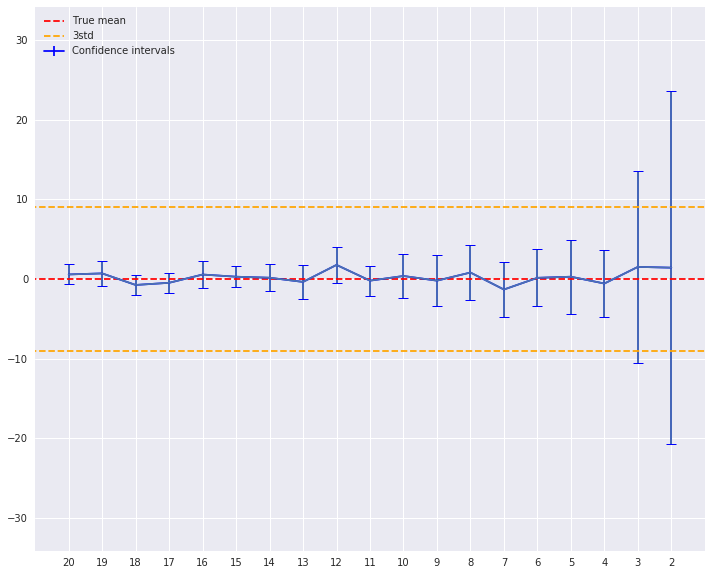

In [180]:
true_mean, x, y, err=get_intervals(0, 3, 20, 0.05)

When sample size is equal 3 or 2, the width of confidence interval blows up. Most of the time it is wider than the true mean +/- 3std. Basically it means that the interval covers almost the whole distribution, thus it isn't useful.

# Problem 2

T-test for independent samples, equal variances:

# $T=\frac{\bar{x}-\bar{y}}{\sqrt{\frac{s^2_x}{n}+\frac{s^2_y}{m}}}$

# $df=n+m-2$


General formula for two sample T-test:

# $T=\frac{\bar{x}-\bar{y}}{\sqrt{D(\bar{x}-\bar{y})}}$

What happen if such test is used for dependent samples?

# $T=\frac{\bar{x}-\bar{y}}{\sqrt{D(\bar{x}-\bar{y})}}=\frac{\bar{x}-\bar{y}}{\sqrt{D(\bar{x})+D(\bar{y})-2cov(x,y)}}$

Thus if $cov(x,y)>0$ the criterion is conservative, the actual distribution of T-statistic will be wider than the distributiom of statistic we compute.

Otherwise, if $cov(x,y)<0$ the criterion is radical.

And if $cov(x,y)=0$ the critetrion is balanced.

In [103]:
def compute_t(sample_1, sample_2, n, m):
    t=(np.mean(sample_1)-np.mean(sample_2))/np.sqrt(np.var(sample_1, ddof=1)/n+np.var(sample_2, ddof=1)/m)
    return t

def simulate_and_compute(means, std, rho, n, m):
    sample=np.random.multivariate_normal(means, [[std, rho], [rho, std]], max(m, n))
    s1=sample[:n, 0] #sample 1
    s2=sample[:m, 1] #sample 2
    t=compute_t(s1, s2, n, m)
    return t

def t_data(covs, N_iter, means, std, n, m):
    
    t_array=np.zeros([len(covs), N_iter])
    df=n+m-2
    
    for i, cov in enumerate(covs):
        for j in range(N_iter):
            
            t_array[i, j]=simulate_and_compute(means, std, cov, n, m)
            
    return t_array, df

def t_plot_pdf(t_array, covs, df):
    for i in range(t_array.shape[0]):
        plt.figure(figsize=[12, 10])
        sns.distplot(t_array[i, :], label='$cov=${}'.format(covs[i]))
        xr=np.linspace(1.1*min(t_array[i, :]), 1.1*max(t_array[i, :]), 100)
        plt.xlim(xr[0], xr[-1])
        plt.plot(xr, stats.t.pdf(xr, df), color='r', linestyle='--', 
                 label='t-distribution $df=${}'.format(df))
        plt.legend()
        
def t_plot_cdf(t_array, covs):
    for i in range(t_array.shape[0]):
        temp=np.sort(t_array[i, :])
        denum=np.sum(temp)
        cdf=np.cumsum(temp)/denum
        plt.figure()
        plt.plot(temp, cdf, label='$cov=${}'.format(covs[i]))
        plt.legend()
        
def fp_count(t_array, covs, df, alphas):
    import pandas as pd
    
    fp_frame=pd.DataFrame(index=covs, columns=alphas)
    for alpha in alphas:
        for i, cov in enumerate(covs):
            fp_count=np.sum(np.logical_or(t_array[i, :]<stats.t.ppf(alpha/2, df), 
                                          t_array[i, :]>stats.t.ppf(1-alpha/2, df)))
            fp_frame.loc[cov, alpha]=fp_count
    fp_frame=fp_frame/t_array.shape[1]
    return fp_frame

def fp_plot(fp_frame, covs, alphas):
    for cov in covs:
        plt.figure(figsize=[10, 8])
        plt.plot(alphas, fp_frame.loc[cov, :], 
                 label='$cov=${}'.format(cov),
                 linestyle='--')
        plt.plot(alphas, alphas, color='red', linestyle='--', label='balanced')
        plt.xticks(alphas)
        plt.legend()

Let's compute distributions of t-statistic for samples with different $\rho=cov(x,y)$ and the same $\mu$, meaning that $H_0$ should hold true for them.

In [74]:
covs=[-0.7, -0.5, 0, 0.5, 0.7]
t_arr, df=t_data(covs, 10000, means=[1, 1], std=4, n=10, m=14)

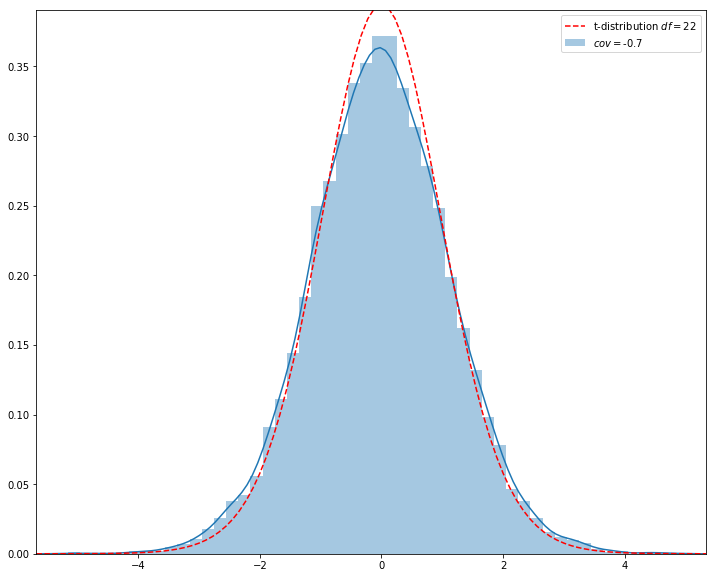

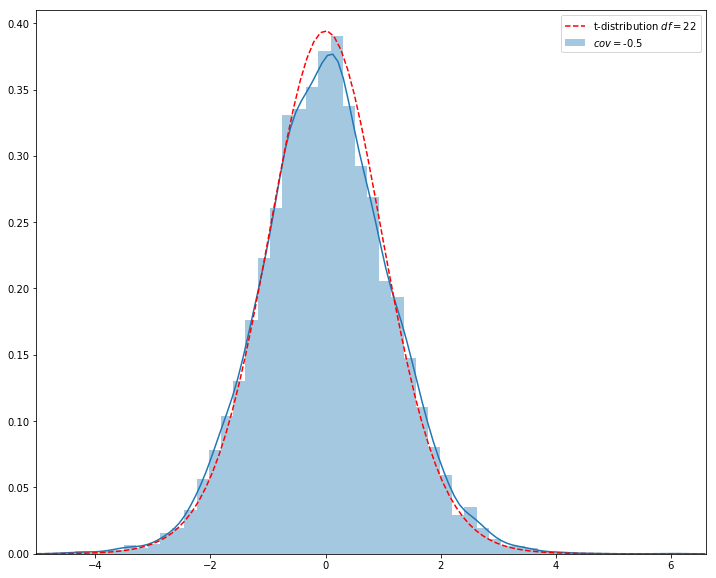

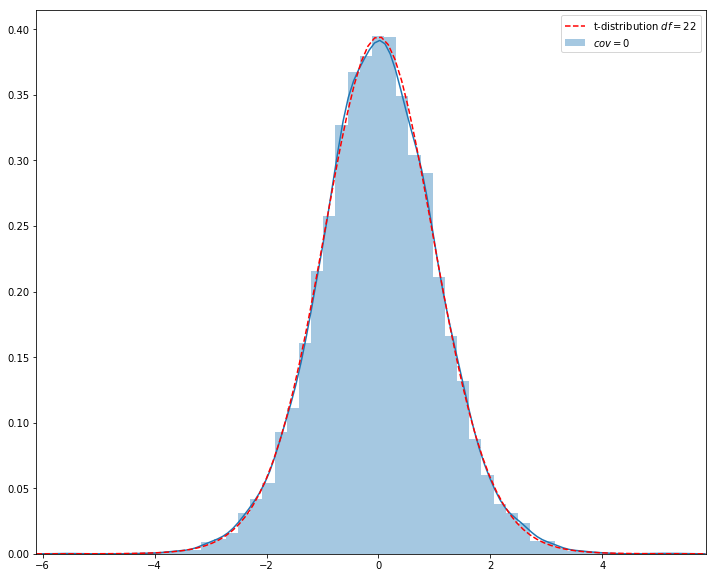

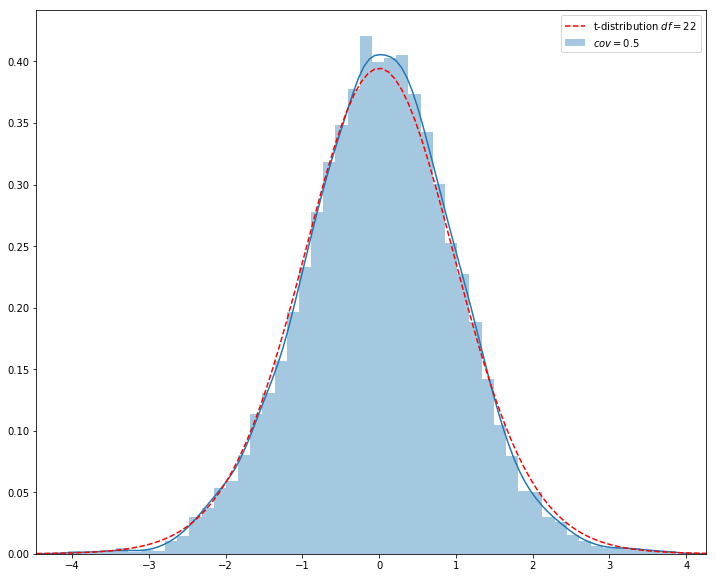

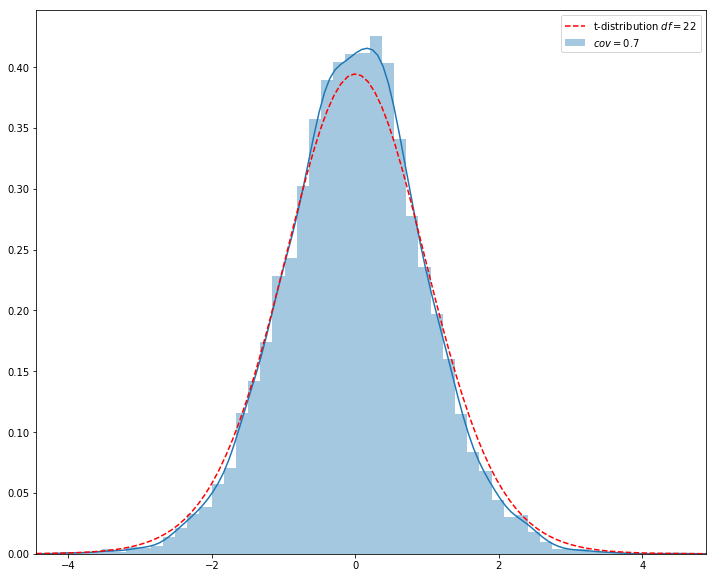

In [75]:
t_plot_pdf(t_arr, covs, df)

The performed computations are consistent with our theoretical result, for $\rho<0$ we get wider distribution, false positive probability would be greater than $p$-value, meaning that criterion is radical.

For $\rho>0$ the actual distribution is narrower, meaning that false positive probaility is smaller.

For $\rho=0$ two distribuions are equal.

## False positive plots

In [92]:
alphas=[0.1, 0.05, 0.01, 0.001]
fp_frame=fp_count(t_arr, covs, df, alphas)
fp_frame

,0.1,0.05,0.01,0.001
-0.7,0.1244,0.0672,0.0161,0.0021
-0.5,0.1203,0.0612,0.0140,0.0019
0.0,0.0983,0.0515,0.0109,0.0008
0.5,0.0849,0.0419,0.0066,0.0006
0.7,0.0772,0.0372,0.0053,0.0004


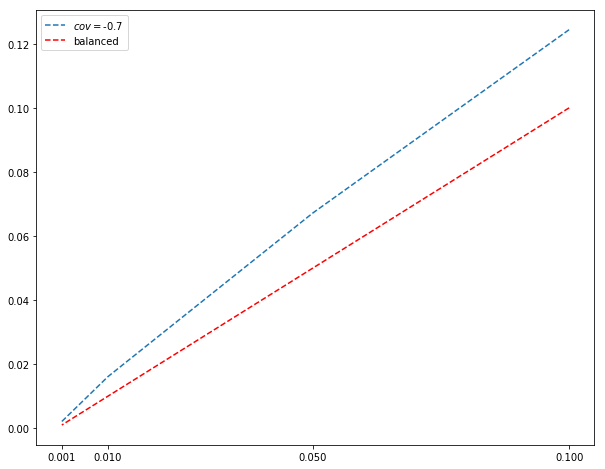

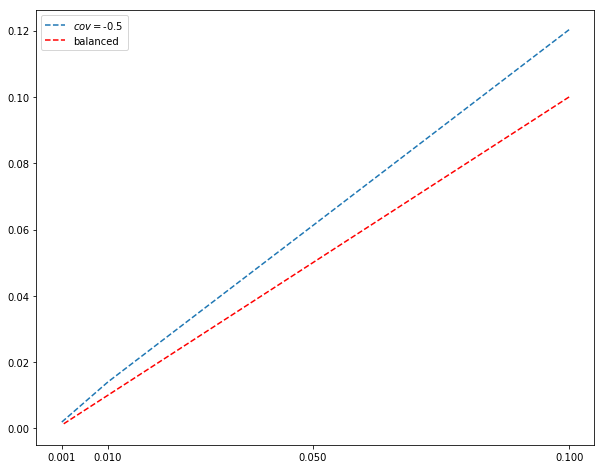

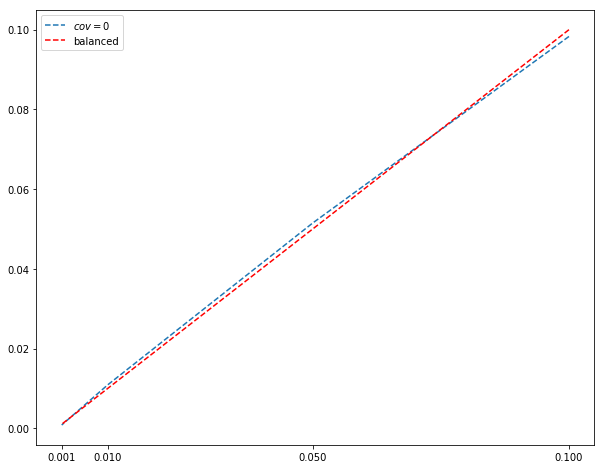

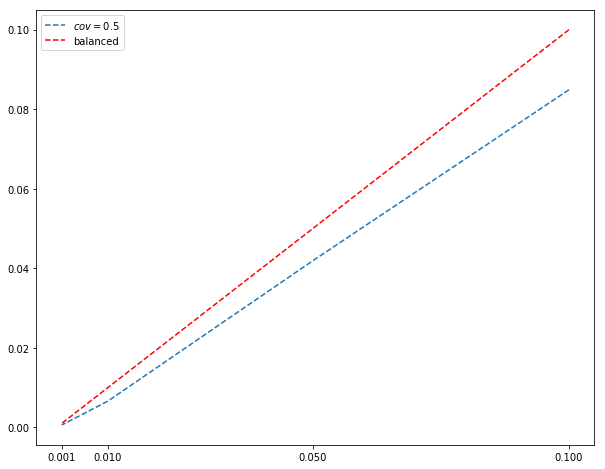

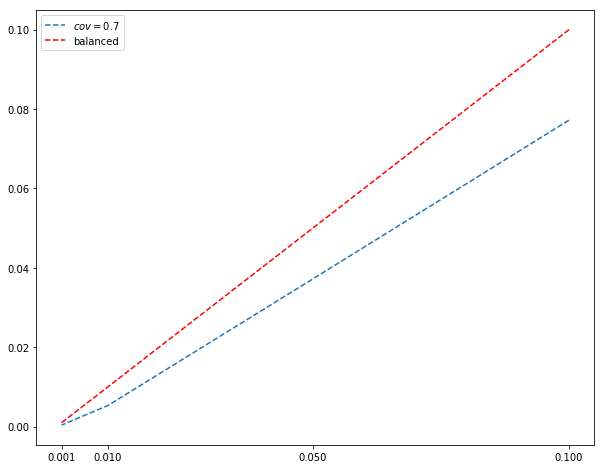

In [104]:
fp_plot(fp_frame, covs, alphas)

The red line in the plots above correspons to the false positive probabilities for a balanced criterion, the blue line shows the probabilities we got for the different values of $\rho$.

This results are consistent with the theoretical statement and the previous simulation.

### False negative simulation

Lets simulate sample with unequal means.

In [113]:
tneq_arr, df=t_data(covs, 10000, means=[1, 2], std=2, n=10, m=14)

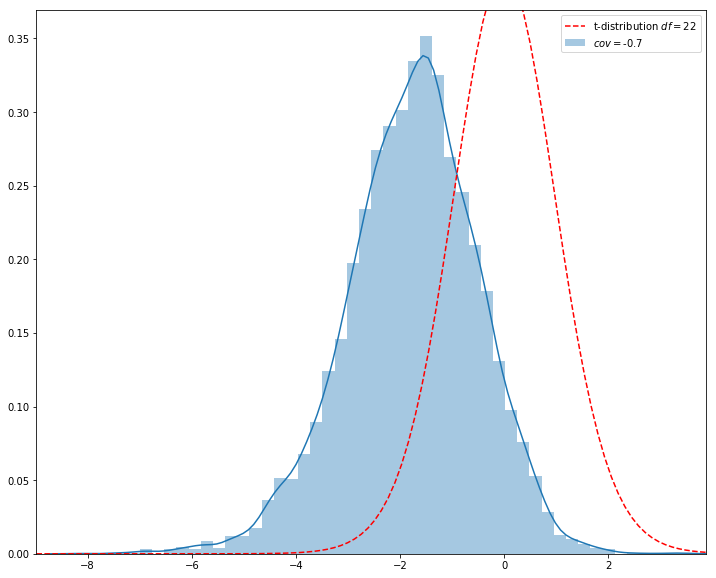

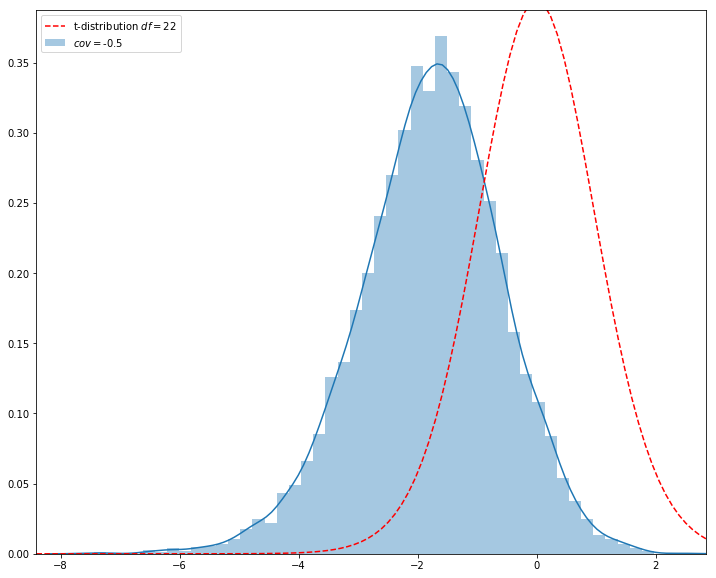

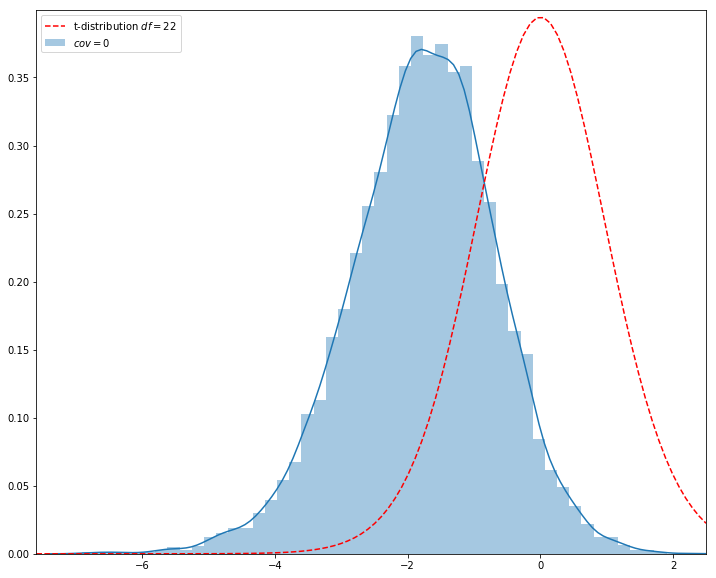

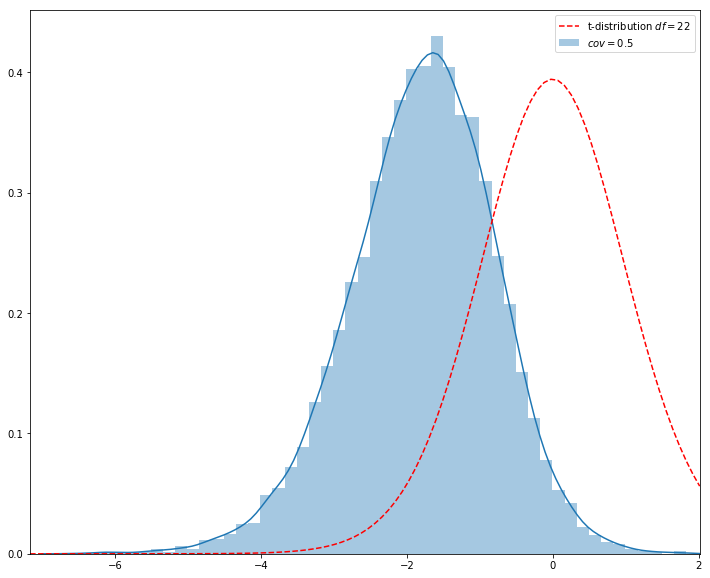

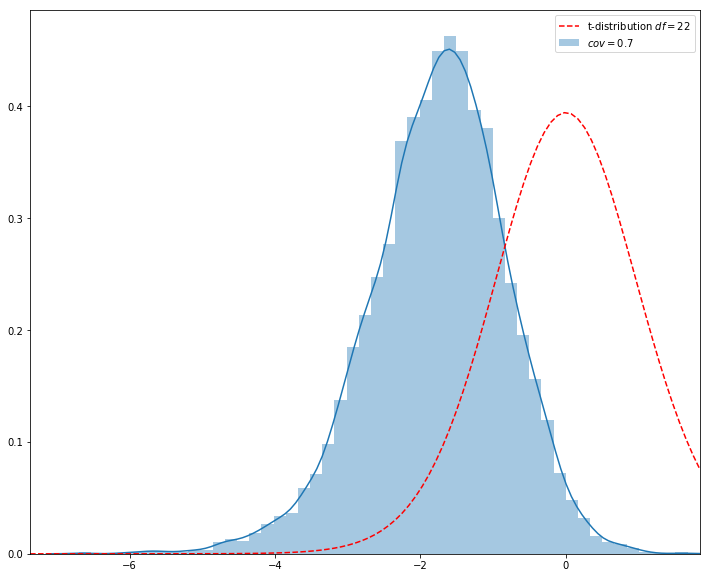

In [114]:
t_plot_pdf(tneq_arr, covs, df)

In [128]:
def fn_count(tneq_array, covs, df, alphas):
    import pandas as pd
    
    fn_frame=pd.DataFrame(index=covs, columns=alphas)
    
    for alpha in alphas:
        for i, cov in enumerate(covs):
            fn_count=np.sum(np.logical_and(tneq_array[i, :]>stats.t.ppf(alpha/2, df), 
                                          tneq_array[i, :]<stats.t.ppf(1-alpha/2, df)))
            fn_frame.loc[cov, alpha]=fn_count
    fn_frame=fn_frame/tneq_array.shape[1]
    return fn_frame

def fn_plot(fn_frame, covs, alphas):
    for cov in covs:
        plt.figure(figsize=[10, 8])
        plt.plot(alphas, fn_frame.loc[cov, :], 
                 label='$cov=${}'.format(cov),
                 linestyle='--')
        plt.plot(alphas, fn_frame.loc[0, :], color='red', linestyle='--', label='balanced')
        plt.xticks(alphas)
        plt.legend()

In [129]:
fn_count=fn_count(tneq_arr, covs, df, alphas)
fn_count

,0.1,0.05,0.01,0.001
-0.7,0.4991,0.6123,0.8095,0.9401
-0.5,0.4960,0.6175,0.8177,0.9495
0.0,0.4930,0.6285,0.8368,0.9615
0.5,0.4903,0.6332,0.8544,0.9704
0.7,0.5031,0.6542,0.8729,0.9759


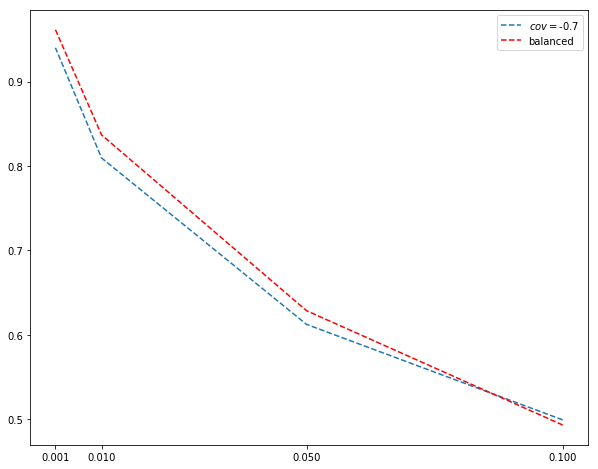

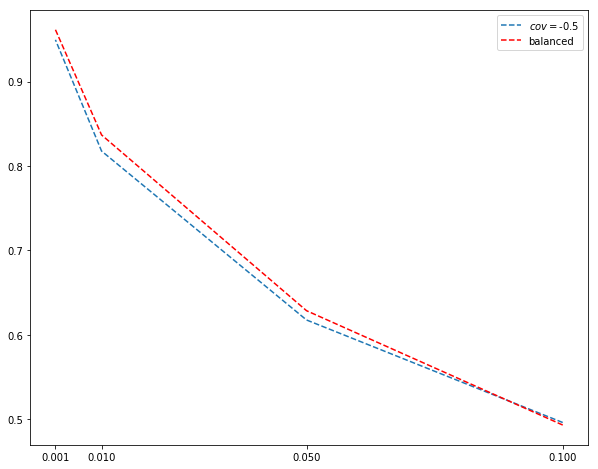

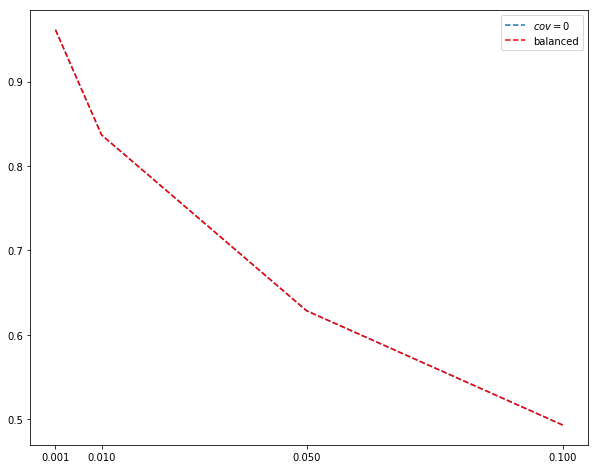

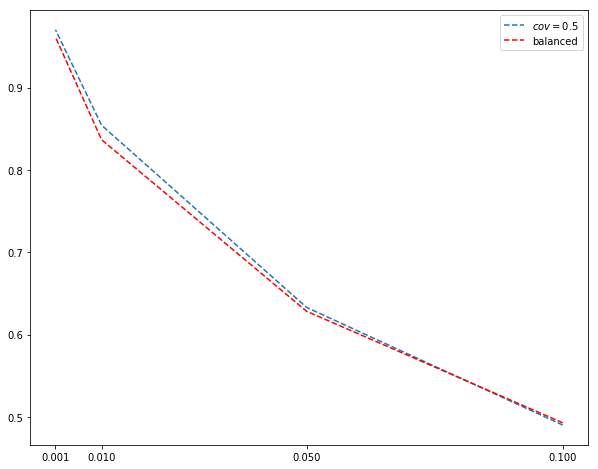

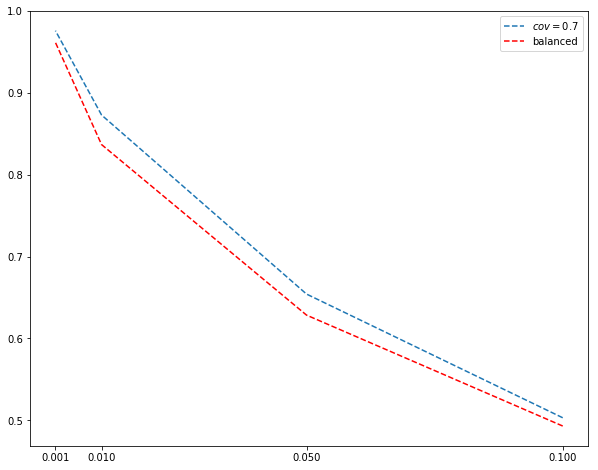

In [131]:
fn_plot(fn_count, covs, alphas)

The behaviour is, for radical criteria false negative probabilites are smaller, and for conservative criteria it is higher.